In [4]:
import numpy as np
from scipy.spatial import distance_matrix
from sklearn.base import BaseEstimator, ClusterMixin

In [94]:
import numpy as np
from sklearn.base import BaseEstimator, ClusterMixin

class DCrawler(BaseEstimator, ClusterMixin):
    def __init__(self, threshold=0.5):
        self.threshold = threshold
        self.labels_ = None
        self.centroids_ = None

    def fit(self, X, y=None):
        n_samples = X.shape[0]
        self.labels_ = [0] * n_samples
        self.centroids_ = []

        for i in range(n_samples):
            if self.labels_[i] == 0:
                self.labels_[i] = len(self.centroids_) + 1
                self.centroids_.append(X[i])
            else:
                distances = np.linalg.norm(self.centroids_ - X[i], axis=1)
                nearest_cluster = np.argmin(distances) + 1
                if distances[nearest_cluster - 1] <= self.threshold:
                    self.labels_[i] = nearest_cluster
                else:
                    self.labels_[i] = len(self.centroids_) + 1
                    self.centroids_.append(X[i])

        while True:
            new_centroids = [np.zeros_like(c) for c in self.centroids_]
            counts = [0] * len(self.centroids_)

            for i in range(n_samples):
                cluster_id = self.labels_[i] - 1
                new_centroids[cluster_id] += X[i]
                counts[cluster_id] += 1

            for i in range(len(self.centroids_)):
                if counts[i] > 0:
                    new_centroids[i] /= counts[i]

            self.centroids_ = new_centroids

            for i in range(n_samples):
                distances = np.linalg.norm(self.centroids_ - X[i], axis=1)
                self.labels_[i] = np.argmin(distances) + 1

            merged = True
            while merged:
                merged = False
                for i in range(len(self.centroids_)):
                    if counts[i] == 0:
                        continue
                    for j in range(i+1, len(self.centroids_)):
                        if counts[j] == 0:
                            continue
                        if np.linalg.norm(self.centroids_[i] - self.centroids_[j]) <= self.threshold:
                            for k in range(n_samples):
                                if self.labels_[k] == j+1:
                                    self.labels_[k] = i+1
                            counts[j] = 0
                            merged = True
                self.centroids_ = [c for i, c in enumerate(self.centroids_) if counts[i] > 0]
                counts = [c for c in counts if c > 0]

            if not merged:
                break

        self.labels_ = np.array(self.labels_)
        return self

    def fit_predict(self, X, y=None):
        self.fit(X)
        return self.labels_

    def predict(self, X):
        distances = np.linalg.norm(self.centroids_ - X[:, np.newaxis], axis=2)
        return np.argmin(distances, axis=1) + 1

In [1]:
# # Generate sample data
# data = np.concatenate([
#     np.random.randn(50, 2) + [0, 0],
#     np.random.randn(50, 2) + [5, 5],
#     np.random.randn(50, 2) + [10, 10]
# ])

# Exxtract demo data
import pandas as pd
data_path = "../DemoData/demodata.csv"
df = pd.read_csv(data_path)
display(df.head())

# Convert df to numpy
data = df.to_numpy()[:,:2]
print(data[:5,:])

,x,y,Cluster
0,1.179043,2.344553,1
1,1.610684,2.242053,1
2,0.247804,1.898954,1
3,1.287104,2.097859,1
4,1.106149,1.737835,1


[[1.17904316 2.34455277]
 [1.61068371 2.24205275]
 [0.247804   1.89895417]
 [1.28710372 2.0978592 ]
 [1.10614882 1.73783483]]


In [93]:
# Function to produce an intermediary plot
import matplotlib.pyplot as plt
def plot_crawler_state(data,cluster_list,centroids,threshold):
    #Inputs
    # data = the x,y positions of the data
    # cluster_list = the list of clusters that the points belong to
    # centroids = the centroid of the clusters
    # threshold = the th(d) value used by dCrawler
    
    #Use an existing figure
    fig = plt.gcf()
    ax = fig.gca()

    n_clust = np.max(cluster_list)
    for i in range(n_clust+1):
        print(i)
        #Unassigned points
        if i==0:
            idx = [pt==i for pt in cluster_list]
            points = data[idx,:]
            lab = 'Unassigned Points'
            plt.scatter(points[:,0],points[:,1], c='grey', label=lab)
        else:
            lab = f"Cluster {i}"
            idx = [pt==i for pt in cluster_list]
            points = data[idx,:]
            plt.scatter(points[:,0],points[:,1], label=lab)
            # Plot registered mean
            plt.scatter(centroids[i-1][0],centroids[i-1][1], marker='X')
            #Calculated mean
            cent = np.mean(points,0)
            pos = [cent[0],cent[1]]
            plt.scatter(pos[0], pos[1], marker='D', c='y')
            # Plot radius of thresholds
            r = plt.Circle((centroids[i-1][0],centroids[i-1][1]), threshold, fill=False, linestyle='--')
            ax.add_patch(r)
    
    plt.legend()

Plotting started
0
1


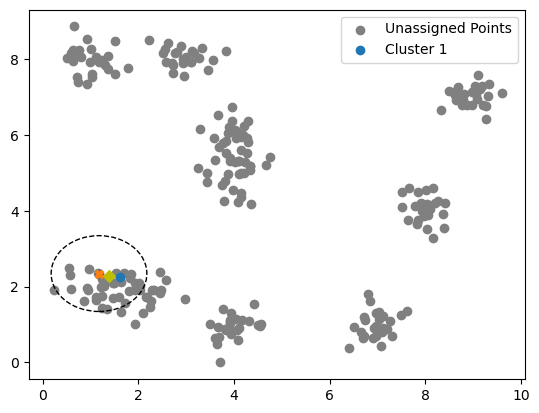

In [92]:
n_points = len(data)
cluster_list = [0] * n_points
cluster_list[0] = 1
cluster_list[1] = 1
centroids = [data[0,:]]
threshold = 1
plot_crawler_state(data,cluster_list,centroids,threshold)

In [96]:
th_range = np.linspace(0.1, 5, 5)
print(len(th_range))
print(th_range)

5
[0.1   1.325 2.55  3.775 5.   ]


In [97]:
dcrawler = DCrawler()
clusterings = []
for th in th_range:
    dcrawler.threshold = th
    labels = dcrawler.fit_predict(data)
    clusterings.append(labels)

NameError: name 'labels' is not defined

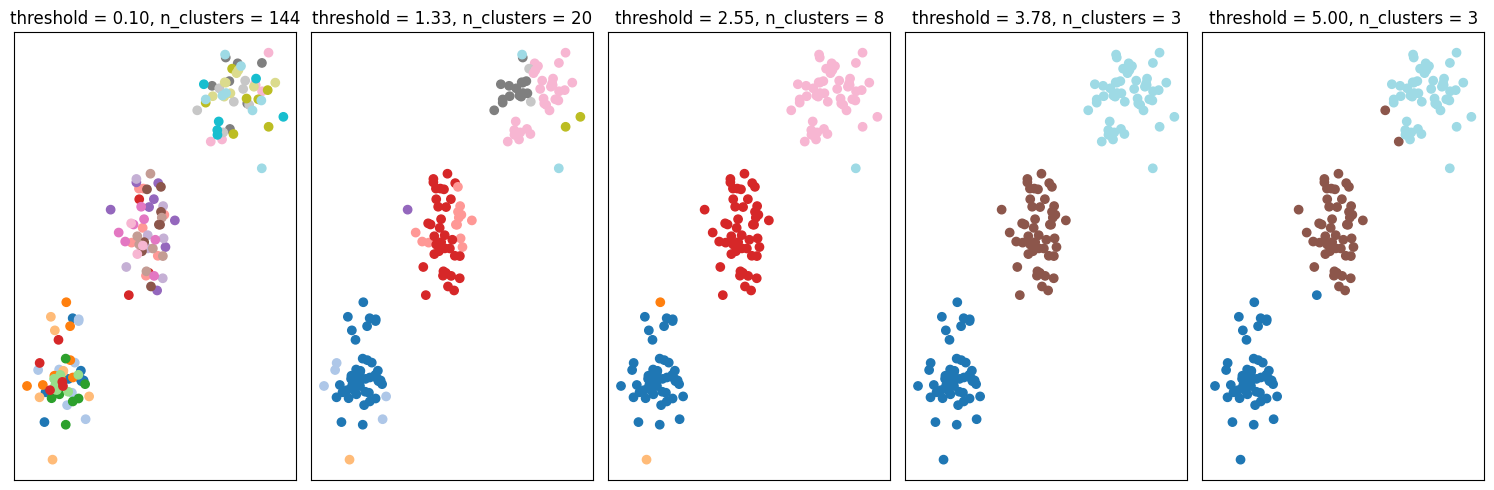

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(1, len(th_range), figsize=(15, 5))
for i, clusters in enumerate(clusterings):
    ax[i].scatter(data[:,0], data[:,1], c=clusters, cmap='tab20')
    ax[i].set_title(f'threshold = {th_range[i]:.2f}, n_clusters = {len(set(clusters))}')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show();